Load modules

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read data

In [ ]:
df = pd.read_csv('creditdata.csv')

In [ ]:
#df.to_csv('drive/MyDrive/df2.csv')

In [ ]:
df.rename({'PAY_0':'PAY_1','default payment next month':'DEFAULT'},inplace=True,axis =1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


Preprocessing

In [ ]:
def PaymentBalance(row):
  if sum([row['BILL_AMT' + str(i)] for i in range(1,7)]) > 0:
    return sum([row['BILL_AMT' + str(i)]- row['PAY_AMT' + str(i)] for i in range(1,7)])/sum([row['BILL_AMT' + str(i)] for i in range(1,7)])
  else:
    return 0

def UsedBalance(row):
  if row['LIMIT_BAL'] > 0:
    return np.mean([row['BILL_AMT' + str(i)]- row['PAY_AMT' + str(i)] for i in range(1,7)])/row['LIMIT_BAL']
  else:
    return 0

def NegativeBal(row):
  return sum([1 for i in range(1,7) if row['BILL_AMT' + str(i)]<0])

def ZeroBal(row):
  return sum([1 for i in range(1,7) if row['BILL_AMT' + str(i)]==0])

def ZeroPay(row):
  return sum([1 for i in range(1,7) if row['PAY_AMT' + str(i)]==0])

df['USED_BAL'] = df.apply(lambda x: UsedBalance(x), axis =1)
df['PAY_BAL']  = df.apply(lambda x: PaymentBalance(x), axis =1)
df['NEG_BAL']  = df.apply(lambda x: NegativeBal(x), axis =1)
df['ZERO_BAL']  = df.apply(lambda x: ZeroBal(x), axis =1)
df['ZERO_PAY']  = df.apply(lambda x: ZeroPay(x), axis =1)

Class Imabalance

In [ ]:
df['DEFAULT'].value_counts()[1]/df['DEFAULT'].count()

0.2212

In [ ]:
categorical_cols = ['SEX','EDUCATION','MARRIAGE','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','NEG_BAL','ZERO_BAL','ZERO_PAY']

One hot encoding

In [ ]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT',
       'USED_BAL', 'PAY_BAL', 'NEG_BAL', 'ZERO_BAL', 'ZERO_PAY'],
      dtype='object')

In [ ]:
df_ID = df['ID']
df = df.drop(['ID'],axis=1)
df = pd.get_dummies(data=df, columns = categorical_cols)
df

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,USED_BAL,PAY_BAL,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_1_-2,PAY_1_-1,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_1_4,PAY_1_5,PAY_1_6,PAY_1_7,...,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,NEG_BAL_0,NEG_BAL_1,NEG_BAL_2,NEG_BAL_3,NEG_BAL_4,NEG_BAL_5,NEG_BAL_6,ZERO_BAL_0,ZERO_BAL_1,ZERO_BAL_2,ZERO_BAL_3,ZERO_BAL_4,ZERO_BAL_5,ZERO_BAL_6,ZERO_PAY_0,ZERO_PAY_1,ZERO_PAY_2,ZERO_PAY_3,ZERO_PAY_4,ZERO_PAY_5,ZERO_PAY_6
0,20000,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0.058458,0.910566,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0.016774,0.707209,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0.167843,0.891612,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0.743153,0.963741,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,0.167633,0.459946,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,39,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0,0.517272,0.941339,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
29996,150000,43,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0,0.007436,0.315929,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
29997,30000,37,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1,0.217756,0.556003,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
29998,80000,41,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1,0.248812,0.447956,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


Dimensionality

In [ ]:
len(df.columns)

115

Train and Validation set

In [ ]:
from sklearn.model_selection import train_test_split
cols = list(set(df.columns) - set(['DEFAULT']))
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,cols],df['DEFAULT'],test_size = 0.05, stratify = df['DEFAULT'])

Scaling for counterfactuals

In [ ]:
X_train_cols = X_train.columns
X_train_cols

Index(['PAY_5_5', 'PAY_4_-1', 'NEG_BAL_5', 'PAY_AMT5', 'PAY_5_6', 'PAY_4_5',
       'NEG_BAL_0', 'SEX_2', 'PAY_2_3', 'PAY_3_1',
       ...
       'PAY_3_5', 'EDUCATION_2', 'PAY_3_6', 'PAY_4_6', 'PAY_6_-2', 'PAY_2_7',
       'ZERO_BAL_4', 'PAY_5_8', 'PAY_3_7', 'NEG_BAL_3'],
      dtype='object', length=114)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train_cols)
X_test  = pd.DataFrame(scaler.transform(X_test),columns=X_train_cols)

In [ ]:
X_test.shape

(1500, 114)

Tensorflow model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ip_shape = X_train.shape[1]#Num input neurons equal to number of rows
output_bias = (df['DEFAULT'].value_counts()[1])/df['DEFAULT'].count()
output_bias = tf.keras.initializers.Constant(output_bias)

model = keras.Sequential(
    [
        keras.Input(shape=(ip_shape)),
        layers.Dense(500, activation='relu'),
        layers.Dense(1000, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1000, activation="relu"),
        layers.Dense(250, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(20,  activation="relu"),
        layers.Dense(1, activation = 'sigmoid', bias_initializer=output_bias),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 500)               57500     
                                                                 
 dense_8 (Dense)             (None, 1000)              501000    
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_9 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_10 (Dense)            (None, 250)               250250    
                                                                 
 dense_11 (Dense)            (None, 100)               25100     
                                                                 
 dense_12 (Dense)            (None, 20)               

In [ ]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
import warnings
warnings.filterwarnings('ignore')

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(lr=0.0001),
    metrics=METRICS,
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_prc', patience=10, mode='max', restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=2048, verbose=1,validation_split=0.4,callbacks=[callback])

Epoch 1/100
9/9 [==============================] - 6s 582ms/step - loss: 0.6737 - accuracy: 0.5943 - auc: 0.4701 - prc: 0.2210 - val_loss: 0.5931 - val_accuracy: 0.7817 - val_auc: 0.4530 - val_prc: 0.1918
Epoch 2/100
9/9 [==============================] - 4s 483ms/step - loss: 0.5891 - accuracy: 0.7769 - auc: 0.5007 - prc: 0.2244 - val_loss: 0.5379 - val_accuracy: 0.7817 - val_auc: 0.6076 - val_prc: 0.4043
Epoch 3/100
9/9 [==============================] - 4s 486ms/step - loss: 0.5347 - accuracy: 0.7799 - auc: 0.6377 - prc: 0.4139 - val_loss: 0.4881 - val_accuracy: 0.8038 - val_auc: 0.7197 - val_prc: 0.4773
Epoch 4/100
9/9 [==============================] - 4s 475ms/step - loss: 0.4852 - accuracy: 0.7988 - auc: 0.7186 - prc: 0.4766 - val_loss: 0.4508 - val_accuracy: 0.8093 - val_auc: 0.7467 - val_prc: 0.4967
Epoch 5/100
9/9 [==============================] - 4s 483ms/step - loss: 0.4591 - accuracy: 0.8046 - auc: 0.7491 - prc: 0.5013 - val_loss: 0.4436 - val_accuracy: 0.8080 - val_auc: 

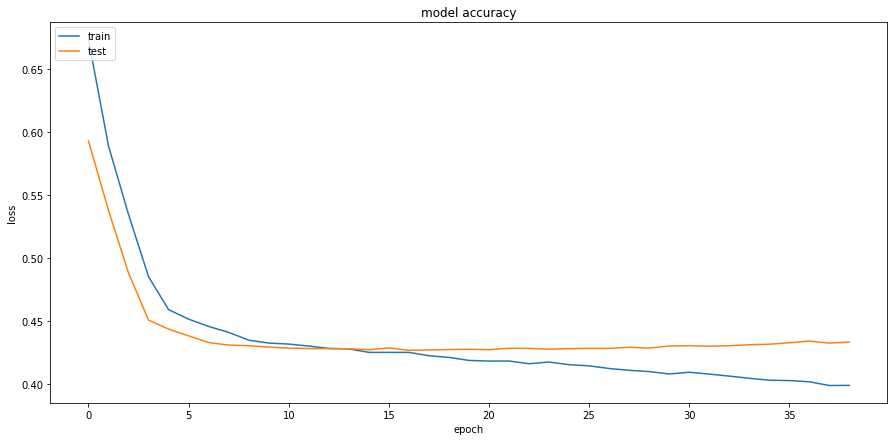

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,7)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_train)
pred[:5]

array([[0.07092178],
       [0.04365671],
       [0.0477173 ],
       [0.0681079 ],
       [0.69186413]], dtype=float32)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
print("Test Score:", rf.score(X_test,y_test))
print("Train Score:", rf.score(X_train,y_train))

Test Score: 0.82
Train Score: 0.9991929824561403


In [ ]:
model.evaluate(X_train,y_train,batch_size=64)

446/446 [==============================] - 4s 10ms/step - loss: 0.4124 - accuracy: 0.8260 - auc: 0.8037 - prc: 0.5897


[0.4123900532722473,
 0.8259999752044678,
 0.8037278652191162,
 0.5896645784378052]

In [ ]:
model.evaluate(X_test,y_test,batch_size=64)

24/24 [==============================] - 0s 10ms/step - loss: 0.4249 - accuracy: 0.8307 - auc: 0.7923 - prc: 0.5533


[0.42494481801986694,
 0.8306666612625122,
 0.7922950387001038,
 0.5532609224319458]

Explainability : Lime

LIME ( Local Interpretable Model-agnostic Explanations )is a novel explanation technique that explains the prediction of any classifier in an interpretable and faithful manner by learning an interpretable model locally around the prediction.

In [ ]:
from lime import lime_tabular
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
test_input = np.array(X_test.iloc[0:10,:])
test_input

array([[-0.02443046,  2.0666265 , -0.05204876, ..., -0.00592359,
        -0.03021777, -0.08940475],
       [-0.02443046, -0.48388037, -0.05204876, ..., -0.00592359,
        -0.03021777, -0.08940475],
       [-0.02443046, -0.48388037, -0.05204876, ..., -0.00592359,
        -0.03021777, -0.08940475],
       ...,
       [-0.02443046, -0.48388037, -0.05204876, ..., -0.00592359,
        -0.03021777, -0.08940475],
       [-0.02443046, -0.48388037, -0.05204876, ..., -0.00592359,
        -0.03021777, -0.08940475],
       [-0.02443046,  2.0666265 , -0.05204876, ..., -0.00592359,
        -0.03021777, -0.08940475]])

In [ ]:
def predictKeras(testData_for_model):
    prediction_Class_1 = model.predict(testData_for_model) 
    x = np.zeros((prediction_Class_1.shape[0], 1))
    probability = (x + 1) - prediction_Class_1
    final = np.append(probability,prediction_Class_1, axis=1)
    return final

pb = predictKeras(X_test)

In [ ]:
# LIME has one explainer for all the models
explainer = lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=['No default','Default'], verbose=True, mode='classification')

In [ ]:
j = 0
exp = explainer.explain_instance(X_test.values[j], predictKeras, num_features=10)
exp.show_in_notebook(show_table=True, show_all=False)

Intercept -0.01717926034401751
Prediction_local [0.2872734]
Right: 0.2263799011707306


Intercept 0.20428275792387182
Prediction_local [0.28657533]
Right: 0.2263799011707306


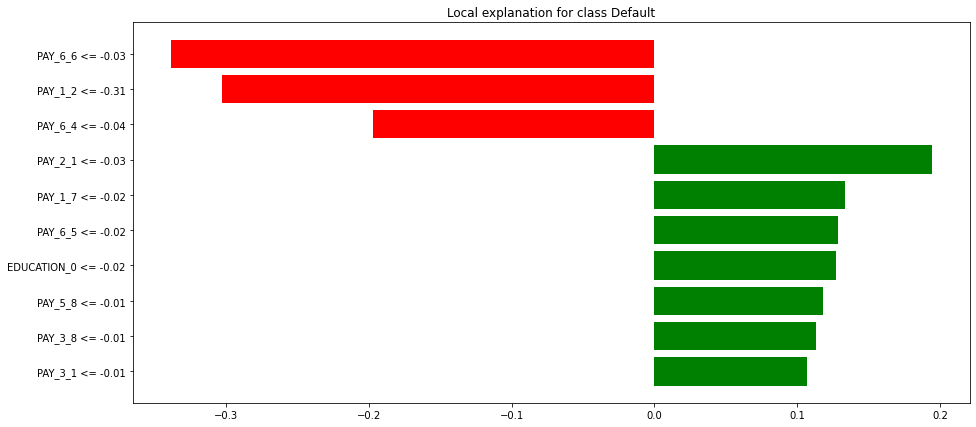

In [ ]:
j = 0
exp = explainer.explain_instance(X_test.values[j], predictKeras, num_features=10)
#exp.show_in_notebook(show_table=True, show_all=False)
(exp.as_pyplot_figure());

Intercept -0.24398738957985128
Prediction_local [0.28367557]
Right: 0.2263799011707306


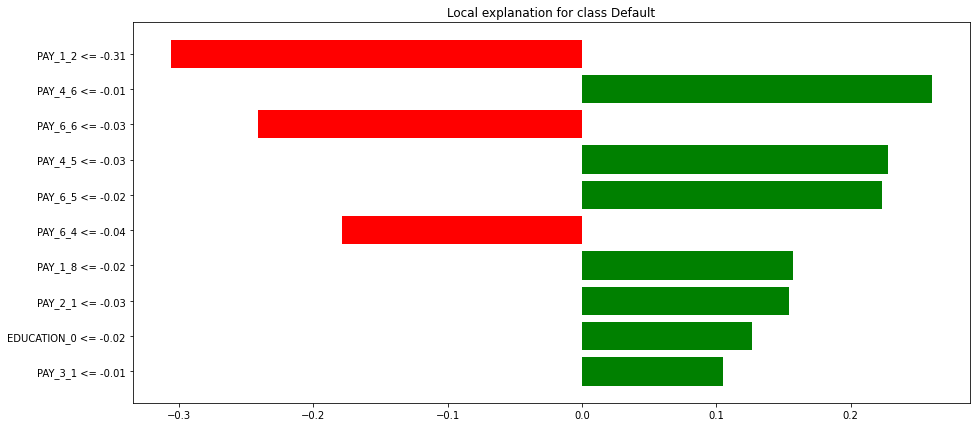

In [ ]:
j = 0
exp = explainer.explain_instance(X_test.values[j], predictKeras, num_features=10)
#exp.show_in_notebook(show_table=True, show_all=False)
(exp.as_pyplot_figure());

Intercept 0.9310280836684582
Prediction_local [0.28143102]
Right: 0.2263799011707306


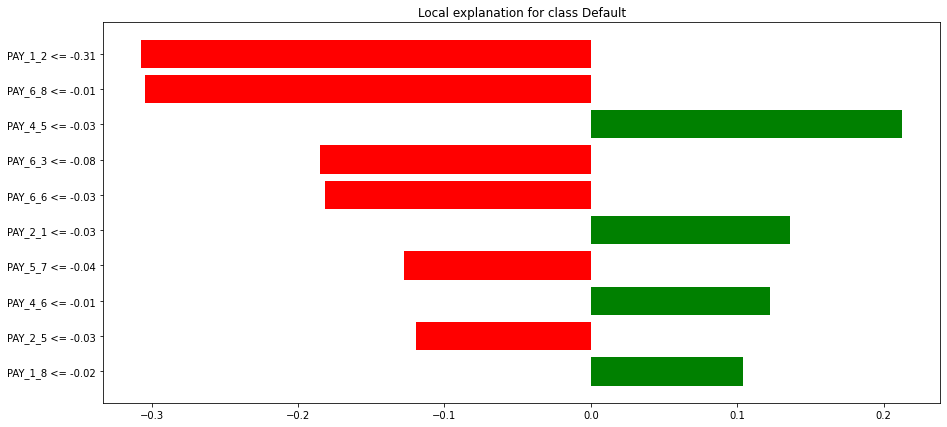

In [ ]:
j = 0
exp = explainer.explain_instance(X_test.values[j], predictKeras, num_features=10)
#exp.show_in_notebook(show_table=True, show_all=False)
(exp.as_pyplot_figure());

Intercept -0.07127109420886585
Prediction_local [0.28420325]
Right: 0.2263799011707306


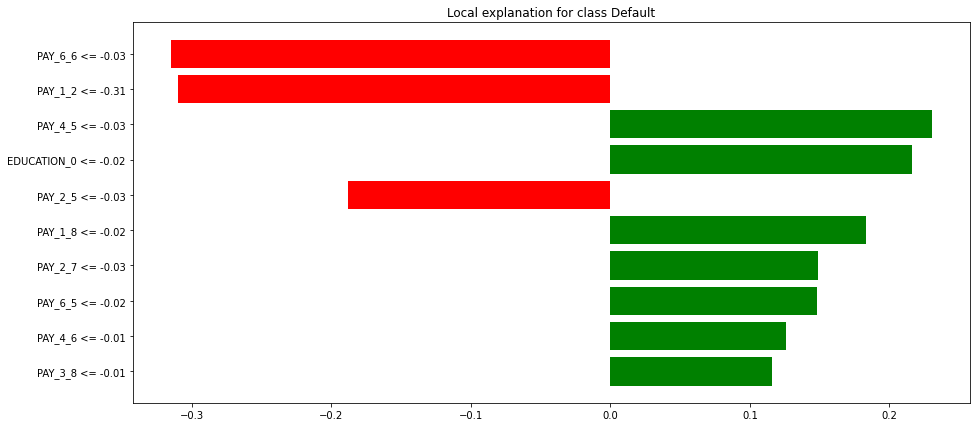

In [ ]:
j = 0
exp = explainer.explain_instance(X_test.values[j], predictKeras, num_features=10)
#exp.show_in_notebook(show_table=True, show_all=False)
(exp.as_pyplot_figure());

As above, given it generates perturbation explanations are not very robust. There is higher consistency while generating lesser number of rules, say 3-4 but some randomness is seen when checking for multiple rules say 10-12.

In [ ]:
X_test.shape[0]

1500

In [ ]:
X_exp = pd.DataFrame({'ID' : df_ID,'Var_1':None,'Var_2':None,'Var_3':None,'Var_4':None,'Var_5':None,
                      'Dir_1':None,'Dir_2':None,'Dir_3':None,'Dir_4':None,'Dir_5':None,
                      'Val_1':df_ID,'Val_2':df_ID,'Val_3':df_ID,'Val_4':df_ID,'Val_5':df_ID})
#print(X_exp)
import random
random.seed(10)
for j in range(len(X_test.iloc[0:20])):
    print('Observation : ',j,'\n')
    exp = explainer.explain_instance(X_test.values[j], predictKeras, num_features=5)
    #print(exp.as_list())
    lst1 = [y.split() for y in [x[0] for x in exp.as_list()]]

    lst2 = [item[0] for item in lst1]
    if(len(lst2)!=5):
        lst2+=(5-len(lst2))*['None']
    lst3 = [item[1] for item in lst1]
    if(len(lst3)!=5):
        lst3+=(5-len(lst3))*['None']
    lst4 = [item[2] for item in lst1]
    if(len(lst4)!=5):
        lst4+=(5-len(lst4))*['None']
    X_exp.iloc[j,1:len(X_exp.columns)] = lst2+lst3+lst4
    print('\n-----------------------------------------------------\n')
    X_exp.to_csv('drive/MyDrive/Lime Interpretations Raw2.csv')



Observation :  0 

Intercept 0.9400731247812464
Prediction_local [0.20754414]
Right: 0.2263799011707306

-----------------------------------------------------

Observation :  1 

Intercept 0.9040639114194087
Prediction_local [0.28118944]
Right: 0.09599408507347107

-----------------------------------------------------

Observation :  2 

Intercept 0.5348967430004512
Prediction_local [0.21945232]
Right: 0.13831716775894165

-----------------------------------------------------

Observation :  3 

Intercept 0.7045446735933032
Prediction_local [0.32497061]
Right: 0.5257735848426819

-----------------------------------------------------

Observation :  4 

Intercept 0.6981245868405151
Prediction_local [0.3445041]
Right: 0.237548828125

-----------------------------------------------------

Observation :  5 

Intercept 0.7559444555035358
Prediction_local [0.16198603]
Right: 0.06623303890228271

-----------------------------------------------------

Observation :  6 

Intercept 0.75997014154

Explainability : Shap

In [ ]:
print(tf.__version__)

2.7.0


In [ ]:
# print the JS visualization code to the notebook
import shap
shap.initjs()

In [ ]:
#Instantiate an explainer with the model predictions and training data summary
explainer = shap.KernelExplainer(model.predict, shap.kmeans(X_train, 10))

In [ ]:

# shap_values = explainer.shap_values(X_test)
# Extract Shapley values from the explainer
shap_values = explainer.shap_values(X_test.iloc[1:100,:].values)
#max_display needed to show more than 20 features
#shap.summary_plot(shap_values, X_new_train, max_display = len(X_new_train.columns))

  0%|          | 0/99 [00:00<?, ?it/s]

In [ ]:
#pd.DataFrame(shap_values[0]).to_csv('drive/MyDrive/shap2.csv')
#Shap for 1500 datapoints
shap_v = pd.read_csv('drive/MyDrive/shap2.csv')


In [ ]:
shap_v = shap_v.iloc[:,1:(len(X_test.columns)+1)]

In [ ]:
(X_test.columns)

Index(['PAY_5_5', 'PAY_4_-1', 'NEG_BAL_5', 'PAY_AMT5', 'PAY_5_6', 'PAY_4_5',
       'NEG_BAL_0', 'SEX_2', 'PAY_2_3', 'PAY_3_1',
       ...
       'PAY_3_5', 'EDUCATION_2', 'PAY_3_6', 'PAY_4_6', 'PAY_6_-2', 'PAY_2_7',
       'ZERO_BAL_4', 'PAY_5_8', 'PAY_3_7', 'NEG_BAL_3'],
      dtype='object', length=114)

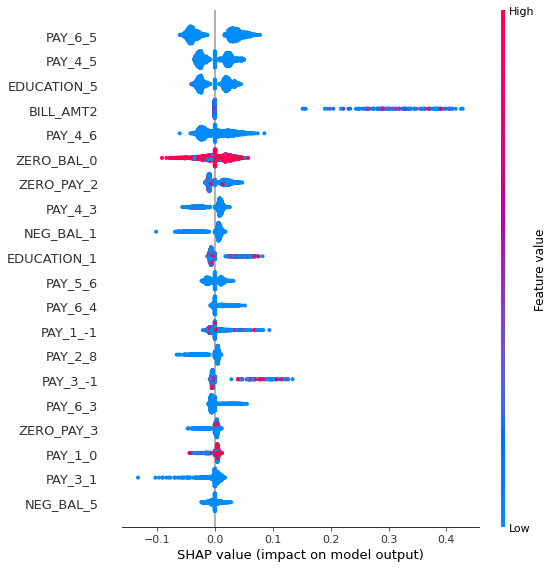

In [ ]:
#shap.initjs()
shap.summary_plot(np.array(shap_v), X_test, max_display = 20)

In [ ]:
# make plot
#shap.initjs()
#shap.dependence_plot('BILL_AMT4' , np.array(shap_v), (X_test) , interaction_index="SEX_1")

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, np.array(shap_v.iloc[0,:]), X_test.iloc[0,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, np.array(shap_v.iloc[0:15,:]), X_test.iloc[0:15,:])

In [ ]:
from alibi.explainers import IntegratedGradients

#model = tf.keras.models.load_model("path_to_your_model")

ig  = IntegratedGradients(model,
                          layer=None,
                          method = "riemann_trapezoid",
                          n_steps=50,
                          internal_batch_size=100)

In [ ]:
explanation = ig.explain(np.array(X_test),
                         baselines=None,
                         target=None)

attributions = explanation.attributions

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


In [ ]:
len(attributions[0])

1500

In [ ]:
np.mean(attributions[0],axis=1)

array([-0.00228212, -0.00338447, -0.00302648, ..., -0.00242419,
       -0.00074205, -0.00351907])

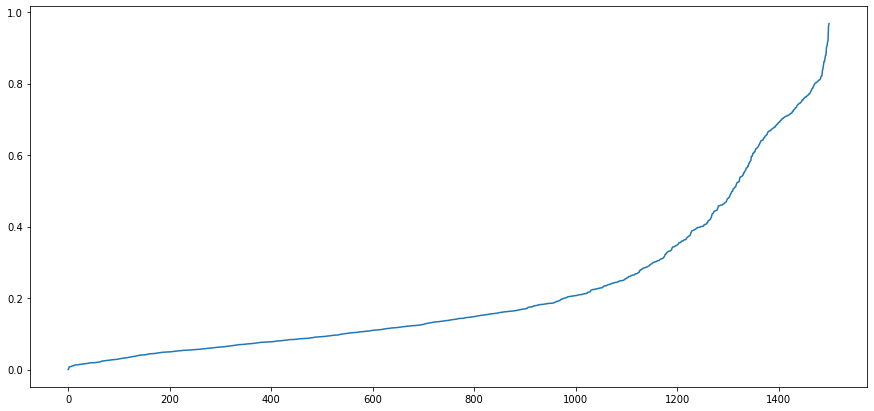

In [ ]:
plt.plot(sorted(model.predict(X_test)))